# Table of Contents
 <p><div class="lev1"><a href="#Some-maps"><span class="toc-item-num">1&nbsp;&nbsp;</span>Some maps</a></div><div class="lev2"><a href="#Example-maps-of-precipitation,-omega_500,-qvstar_925"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Example maps of precipitation, omega_500, qvstar_925</a></div><div class="lev3"><a href="#Daily"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Daily</a></div><div class="lev2"><a href="#Example-maps-of-coarsened-precipitation"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Example maps of coarsened precipitation</a></div><div class="lev3"><a href="#Coasen-in-time"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Coasen in time</a></div><div class="lev3"><a href="#Coarsen-in-space"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Coarsen in space</a></div><div class="lev1"><a href="#Figures-at-a-specific-scale"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figures at a specific scale</a></div><div class="lev1"><a href="#Multiscale-figures"><span class="toc-item-num">3&nbsp;&nbsp;</span>Multiscale figures</a></div>

In [1]:
%load_ext autoreload
%matplotlib inline

In [71]:
%autoreload 2

import pandas as pd
import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib.pyplot as plt
from matplotlib import mplDeprecation
import datetime as dt
import sys,os,glob
import matplotlib
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm
import pickle

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from importingData import *
from scalingApproximations import *
from plotMaps import *
from plot1DInvLog import *
from statisticalDistributions import *
from slicingAndSubsetting import *
from outputResults import *
from CAMsettings import *
from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['plot1DInvLog', 'thermoFunctions', 'statisticalDistributions', 'slicingAndSubsetting', 'plot2D', 'outputResults', 'thermoConstants', 'plotMaps', 'daskOptions', 'scalingApproximations', 'CAMsettings', 'environmentAndDirectories', 'importingData', 'physicalConstants']


In [9]:
# time_strides = '1h','3h','6h','12h','1d','2d','4d','8d'
time_strides = '3h','6h','12h','1d','2d','4d','8d'
resolutions = '1dx','2dx','3dx','4dx','5dx','6dx','7dx','8dx'
N_times = len(time_strides)
N_res = len(resolutions)

ranks_label = 'Q8-Q41'
dates_label = '185005010100-185105010000'

In [10]:
print("missing results")
for experiment in 'piControl','abrupt4xCO2':
    for compset in 'FSPCAMm_AMIP','FAMIPC5':

        resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,'r1i1p1','tropics')
        missing_dictionary = []
        for time_stride in time_strides:
            for resolution in resolutions:
                filename = 'results_dictionary_%s_%s.pickle'%(ranks_label,dates_label)
                dirpath = os.path.join(resultdir,time_stride,resolution)
                if not np.any(['dictionary' in p for p in glob.glob(os.path.join(dirpath,'*'))]):
                    missing_dictionary.append("%s_%s"%(time_stride,resolution))

        print(experiment,compset,missing_dictionary)

missing results
piControl FSPCAMm_AMIP []
piControl FAMIPC5 []
abrupt4xCO2 FSPCAMm_AMIP []
abrupt4xCO2 FAMIPC5 []


In [11]:
print("choose run options")
scaling = 'omega500tsps'
compset = 'FSPCAMm_AMIP'
# compset = 'FAMIPC5'
experiment = 'piControl'
member = 'r1i1p1'
subset = 'tropics'
time_ref = '1h'
res_ref = '1dx'
daskarray = False

choose run options


In [12]:
# Results to analyze
resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,member,subset)

# Figure output directory
figdir = os.path.join(os.path.dirname(workdir),'figures','omega500tsps',compset,experiment,member,subset)

print()
print("get inputpaths")

# Local input directory
historyFilesSettings = getCAMHistoryFilesSettings()
inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)


get inputpaths


# Some maps

## Example maps of precipitation, omega_500, qvstar_925

In [13]:
## Get longitude, latitude and landmask
print("load lontigude, latitude and landmask")

fh = Dataset(os.path.join(inputdir_fx,'landmask_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'))
lon1D = fh.variables['lon'][:]
lat1D = fh.variables['lat'][:]
lon2D, lat2D = np.meshgrid(lon1D,lat1D)
lon2D = da.from_array(lon2D,chunks=lon2D.shape)
lat2D = da.from_array(lat2D,chunks=lat2D.shape)


landmask = fh.variables['landmask']


load lontigude, latitude and landmask


In [14]:
print("load physical variables data")

omega_id = 'OMEGA'
pr_id = 'PRECT'
ts_id = 'TS'
ta_id = 'T'
relhum_id = 'RELHUM'
ps_id = 'PS'
dates_maps = '185005010100','185005080000'
handle = 'h0'

output_suffix_maps = '%s'%('-'.join(dates_maps))

omega,pr,ta,relhum,ps = \
    getValues([omega_id,pr_id,ta_id,relhum_id,ps_id],
              compset,subset,experiment,time_ref,res_ref,
              daskarray=daskarray,dates=dates_maps,handle=handle)
pr *= rho_l    # convert from m/s to kg/m2/s

print("compute pressure levels")
    
input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)
pres = computeP(ps)

load physical variables data
Importing OMEGA, PRECT, T, RELHUM, PS from 168 history files between 1850-05-01-03600 and 1850-05-08-00000
compute pressure levels


In [15]:
%%time
print("compute 2D surfaces of predictor variables")
p_500 = 50000
p_925 = 92500; levdim=1
omega_500 = isobaricSurface(omega,pres,p_ref=p_500,levdim=levdim)
use925 = True
if use925:
    ta_925 = isobaricSurface(ta,pres,p_ref=p_925,levdim=levdim) 
    qvstar_925 = saturationSpecificHumidity(ta_925,p_925*np.ones(ps.shape))
else:
    qvstar_s = saturationSpecificHumidity(ts,ps)

compute 2D surfaces of predictor variables
CPU times: user 12.1 s, sys: 4.21 s, total: 16.3 s
Wall time: 16.3 s


### Daily

In [16]:
%%time
print("coarsen variables to daily")
pr_day = coarsenTimeStride(pr,'1d')
omega_500_day = coarsenTimeStride(omega_500,'1d')
qvstar_925_day = coarsenTimeStride(qvstar_925,'1d')

coarsen variables to daily
CPU times: user 3.86 ms, sys: 4.11 ms, total: 7.96 ms
Wall time: 6.81 ms


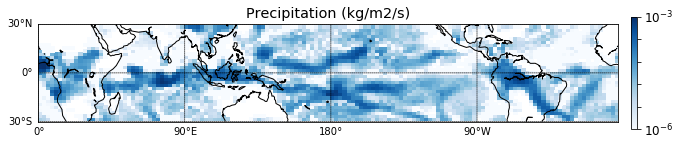

In [17]:
warnings.simplefilter("ignore",category=mplDeprecation)
plotMapTropics(lon2D,lat2D,pr_day[0],title='Precipitation (kg/m2/s)',cmap=plt.cm.Blues,
               v_min=1e-6,v_max=1e-3,mode='log',plotfunction='pcolormesh')
plt.savefig(os.path.join(figdir,'talkAGU2017_map_pr_day_%s_%s_%s.pdf'%(experiment,compset,output_suffix_maps)),
            bbox_inches='tight')

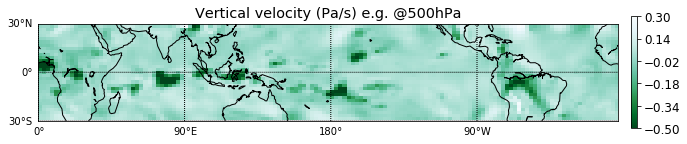

In [18]:
plotMapTropics(lon2D,lat2D,omega_500[0],title='Vertical velocity (Pa/s) e.g. @500hPa',cmap=plt.cm.BuGn_r,
               v_min=-0.5,v_max=0.3,mode='linear',plotfunction='pcolormesh')
plt.savefig(os.path.join(figdir,'talkAGU2017_map_omega_500_day_%s_%s_%s.pdf'%(experiment,compset,output_suffix_maps)),
            bbox_inches='tight')

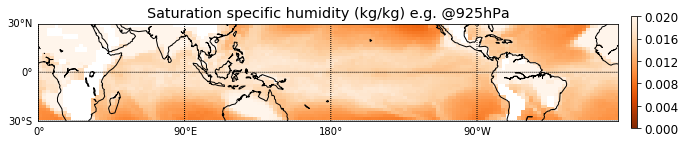

In [19]:
plotMapTropics(lon2D,lat2D,qvstar_925[0],title='Saturation specific humidity (kg/kg) e.g. @925hPa',cmap=plt.cm.Oranges_r,
               v_min =0,v_max=0.02,mode='linear',plotfunction='pcolormesh')
plt.savefig(os.path.join(figdir,'talkAGU2017_map_qvstar_925_day_%s_%s_%s.pdf'%(experiment,compset,output_suffix_maps)),
            bbox_inches='tight')

## Example maps of coarsened precipitation

### Coasen in time

In [20]:
print("coarsen pr to weekly")
pr_week = coarsenTimeStride(pr,'7d')

coarsen pr to weekly


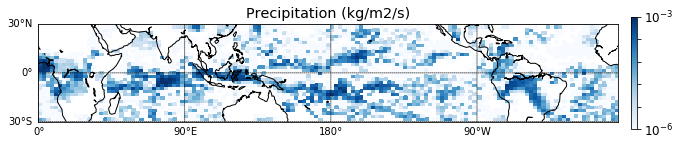

In [38]:
plotMapTropics(lon2D,lat2D,pr[0],title='Precipitation (kg/m2/s)',cmap=plt.cm.Blues,
               v_min=1e-6,v_max=1e-3,mode='log',plotfunction='pcolormesh')
plt.savefig(os.path.join(figdir,'talkAGU2017_map_pr_1h_%s_%s_%s.pdf'%(experiment,compset,output_suffix_maps)),
            bbox_inches='tight')

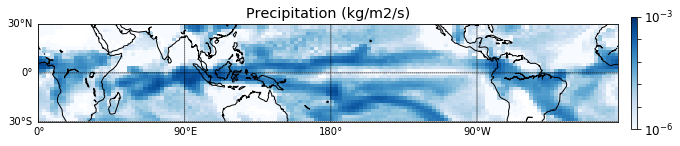

In [69]:
plotMapTropics(lon2D,lat2D,pr_week[0],title='Precipitation (kg/m2/s)',cmap=plt.cm.Blues,
               v_min=1e-6,v_max=1e-3,mode='log',plotfunction='pcolormesh')
plt.savefig(os.path.join(figdir,'talkAGU2017_map_pr_week_%s_%s_%s.pdf'%(experiment,compset,output_suffix_maps)),
            bbox_inches='tight')

### Coarsen in space

In [23]:
print("coarsen pr in space")
pr_day_2dx = coarsenResolution(pr_day,'2dx')
pr_day_4dx = coarsenResolution(pr_day,'4dx')

lon2D_2dx = coarsenResolution(lon2D,'2dx')
lon2D_4dx = coarsenResolution(lon2D,'4dx')
lat2D_2dx = coarsenResolution(lat2D,'2dx')
lat2D_4dx = coarsenResolution(lat2D,'4dx')

coarsen pr in space


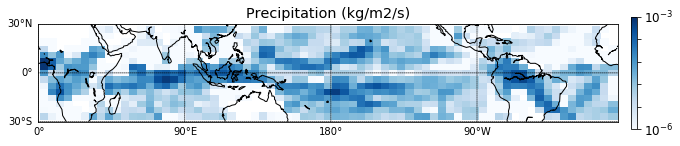

In [24]:
plotMapTropics(lon2D_2dx,lat2D_2dx,pr_day_2dx[0],title='Precipitation (kg/m2/s)',cmap=plt.cm.Blues,
               v_min=1e-6,v_max=1e-3,mode='log',plotfunction='pcolormesh')
plt.savefig(os.path.join(figdir,'talkAGU2017_map_pr_day_2dx_%s_%s_%s.pdf'%(experiment,compset,output_suffix_maps)),
            bbox_inches='tight')

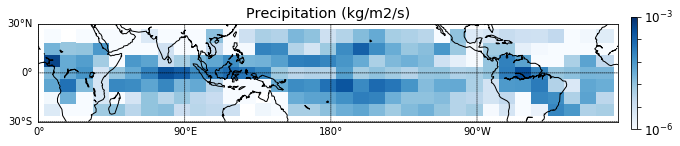

In [25]:
plotMapTropics(lon2D_4dx,lat2D_4dx,pr_day_4dx[0],title='Precipitation (kg/m2/s)',cmap=plt.cm.Blues,
               v_min=1e-6,v_max=1e-3,mode='log',plotfunction='pcolormesh')
plt.savefig(os.path.join(figdir,'talkAGU2017_map_pr_day_4dx_%s_%s_%s.pdf'%(experiment,compset,output_suffix_maps)),
            bbox_inches='tight')

# Figures at a specific scale

In [26]:
print("Load results as a dictionary")
results = {}
for time_stride in time_strides:
    results[time_stride] = {}
    for resolution in resolutions:
        filename = 'results_dictionary_%s_%s.pickle'%(ranks_label,dates_label)
        filepath = os.path.join(resultdir,time_stride,resolution,filename)
        results[time_stride][resolution] = pickle.load(open(filepath,'rb'))

all_varids = results['3h'][res_ref].keys()

Load results as a dictionary


In [27]:
print("choose one scale")
time_to_show = '1d'
res_to_show = '1dx'
results_dict = results[time_to_show][res_to_show]

choose one scale


In [28]:
print([v for v in results_dict.keys() if 'iQ_' in v])

[]


In [29]:
ranks_ref = results_dict['ranks_ref']
i_Q = indexOfRank(99.9,ranks_ref)
iQ_slice = slice(i_Q-5,i_Q+5)
iQ_min = 8
iQ_max = len(results_dict['ranks_ref'])

output_suffix_1scale = '%s_%s_%s'%(experiment,compset,dates_label)

## Vertical profiles

In [30]:
ranks, centers, bins = computePercentilesAndBinsFromRanks(pr.flatten(),ranks_ref)
percentiles = adjustRanks(centers,ranks,ranks_ref)

rank_locations= {}
for rank in ranks_ref:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations[rank_id] = getRankLocations(rank,pr,ranks,bins,rank_locations)
print()

0.0000 20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 99.9900 


In [31]:
iQ_slice_profiles = slice(i_Q,i_Q+1)
iQ_ref = range(100)[iQ_slice_profiles]


varnames_for_profiles = ('omega','ta','pres')

ranks_tune = ["%2.4f"%(ranks_ref[iQ-1]) for iQ in iQ_ref]
# Initialize list for each variable
for varname in varnames_for_profiles:
    setattr(thismodule,"%s_ref_list"%varname,[])
# fill list with sample variables at each percentile
for rank in ranks_tune:
    stencil_Q = rank_locations[rank]
    for varname in varnames_for_profiles:
        var = getattr(thismodule,varname)
        var_list = getattr(thismodule,"%s_ref_list"%varname)
        var_list.append(sampleFlattened(var,stencil_Q))
# concat arrays from list
for varname in varnames_for_profiles:
    var_list = getattr(thismodule,"%s_ref_list"%varname)
    setattr(thismodule,"%s_ref"%varname,np.hstack(var_list))

qvstar_ref = saturationSpecificHumidity(ta_ref,pres_ref)

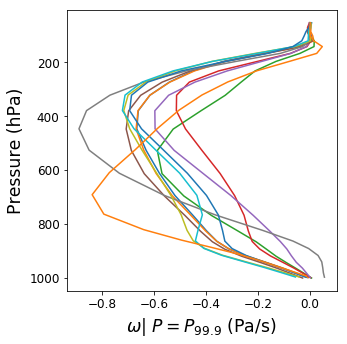

In [66]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,5))
var_to_plot = omega_ref.copy()
var_to_plot[:,6] = np.nan
for i in range(var_to_plot.shape[1])[:12]:
    ax.plot(var_to_plot[5:,i],pres_ref[5:,i]/100)
ax.invert_yaxis()
ax.set_xlabel(r'$\omega |\,\, P=P_{99.9}$ (Pa/s)',fontsize='xx-large')
ax.set_ylabel('Pressure (hPa)',fontsize='xx-large')
plt.savefig(os.path.join(figdir,'talkAGU2017_omega_profiles_Q999_%s_%s_%s.pdf'%(experiment,compset,output_suffix_1scale)),
            bbox_inches='tight')

In [33]:
pres_ref_mean = np.mean(pres_ref,axis=1)
omega_ref_mean = np.mean(omega_ref,axis=1)
qvstar_ref_mean = np.mean(qvstar_ref,axis=1)

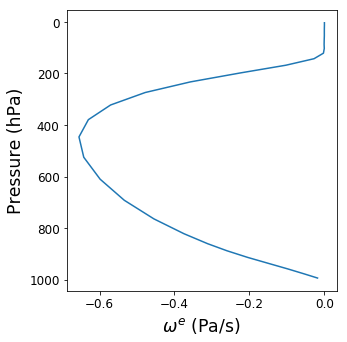

In [58]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,5))
ax.plot(omega_ref_mean,pres_ref_mean/100)
ax.invert_yaxis()
ax.set_xlabel(r'$\omega^e$ (Pa/s)',fontsize='xx-large')
ax.set_ylabel('Pressure (hPa)',fontsize='xx-large')
plt.savefig(os.path.join(figdir,'talkAGU2017_ref_omega_profile_Q999_%s_%s_%s.pdf'%(experiment,compset,output_suffix_1scale)),
            bbox_inches='tight')

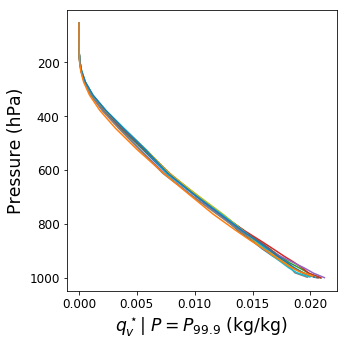

In [64]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,5))
var_to_plot = qvstar_ref.copy()
var_to_plot[:,6] = np.nan
for i in range(var_to_plot.shape[1])[:12]:
    ax.plot(var_to_plot[5:,i],pres_ref[5:,i]/100)
ax.invert_yaxis()
ax.set_xlabel(r'$q_v^\star  |\,\, P=P_{99.9}$ (kg/kg)',fontsize='xx-large')
ax.set_ylabel('Pressure (hPa)',fontsize='xx-large')
plt.savefig(os.path.join(figdir,'talkAGU2017_qvstar_profiles_Q999_%s_%s_%s.pdf'%(experiment,compset,output_suffix_1scale)),
            bbox_inches='tight')

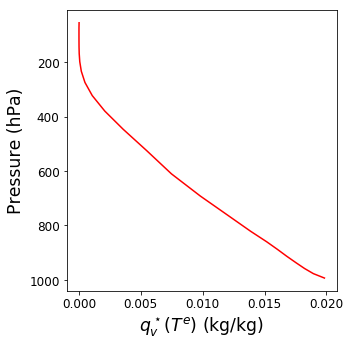

In [65]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,5))
ax.plot(qvstar_ref_mean[5:],pres_ref_mean[5:]/100,'r')
ax.invert_yaxis()
ax.set_xlabel(r'$q_v^\star(T^e)$ (kg/kg)',fontsize='xx-large')
ax.set_ylabel('Pressure (hPa)',fontsize='xx-large')
plt.savefig(os.path.join(figdir,'talkAGU2017_ref_qvstar_profile_Q999_%s_%s_%s.pdf'%(experiment,compset,output_suffix_1scale)),
            bbox_inches='tight')

## 1D PDFs

### In a precipitation bin

In [39]:
iQ_start = i_Q-3
iQ_stop = i_Q+3

> Plot pdf of last computed conditioned on high percentiles of pr


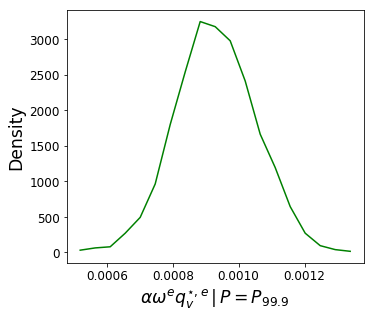

In [70]:
print("> Plot pdf of last computed conditioned on high percentiles of pr")

# varname = 'pr_scOGS09'
varname = 'pr_sc'
varname_ref = 'pr'

perc_name = 'percentiles_%s_%s_Q%dQ%d'%(varname,varname_ref,iQ_start,iQ_stop)
den_name = 'pdf1D_%s_%s_Q%dQ%d'%(varname,varname_ref,iQ_start,iQ_stop)

fig,ax = plt.subplots(figsize=(5.5,4.5))
plt.plot(results_dict[perc_name],results_dict[den_name],'g')
ax.set_xlabel(r"$\alpha \omega^e q_v^{\star,e}\,|\,P=P_{99.9}$",fontsize='xx-large')
ax.set_ylabel('Density',fontsize='xx-large')

plt.savefig(os.path.join(figdir,'talkAGU2017_conditional_pdf_%s_%s_%2.4f_%2.4f_%s.pdf'%(varname,varname_ref,
                                                                            ranks_ref[iQ_start],
                                                                            ranks_ref[iQ_stop],
                                                                            output_suffix_1scale)),
                bbox_inches='tight')

plt.show()

### Precipitation and scalings

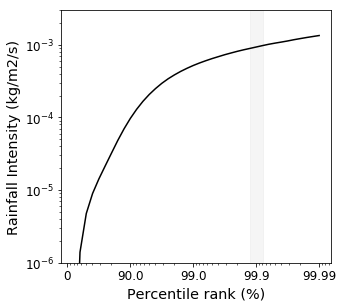

In [41]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_yscale('log')
ax.set_ylim((1e-6,3e-3))

# iQ_plot = slice(iQ_min,iQ_max)

# Grey shading 
i_Q_lims = (iQ_slice.start+4, iQ_slice.stop-4)
subplotXShadingRanksILog(ax,results_dict['ranks_ref'],i_Q_lims,alpha=0.15,transformX=False)
subplotRanksILog(ax,results_dict['ranks_ref'],[results_dict['percentiles']],col=['k'],ltype=['-'],\
                 transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel('Rainfall Intensity (kg/m2/s)')

plt.savefig(os.path.join(figdir,'talkAGU2017_pdf_pr_%s.pdf'%(output_suffix_1scale)),
            bbox_inches='tight',transparent=True)

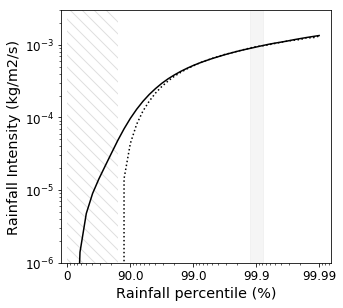

In [72]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_yscale('log')
ax.set_ylim((1e-6,3e-3))

# iQ_plot = slice(iQ_min,iQ_max)

# Grey shading 
i_Q_lims = (iQ_slice.start+4, iQ_slice.stop-4)
subplotXShadingRanksILog(ax,results_dict['ranks_ref'],i_Q_lims,alpha=0.15,transformX=False)
# 90% confidence interval for pointwise scaling 2
# subplotYShadingRanksILog(ax,results_dict['ranks_ref'],[results_dict['pr_sc_I90'][:,0],results_dict['pr_sc_I90'][:,1]],
#                          col='green',transformX=False)
# Interquartile range for pointwise scaling 2
# subplotYShadingRanksILog(ax,results_dict['ranks_ref'],[results_dict['pr_sc_IQR'][:,0],results_dict['pr_sc_IQR'][:,1]],
#                          col='green',transformX=False)
# Mean of pointwise scaling 2
subplotRanksILog(ax,results_dict['ranks_ref'],[results_dict['percentiles'],
                                               results_dict['pr_sc_vQ']],col=['k','k'],ltype=['-',':'],\
                 transformX=False)

addXHatchRanksILog(ax,results_dict['ranks_ref'],(0,iQ_min),color='gray',alpha=0.25,hatch='\\\\',transformX=True)

ax.set_xlabel('Rainfall percentile (%)')
ax.set_ylabel('Rainfall Intensity (kg/m2/s)')

plt.savefig(os.path.join(figdir,'talkAGU2017_pdf_pr_and_pr_sc_mean_grayzone_%s.pdf'%(output_suffix_1scale)),
            bbox_inches='tight',transparent=True)

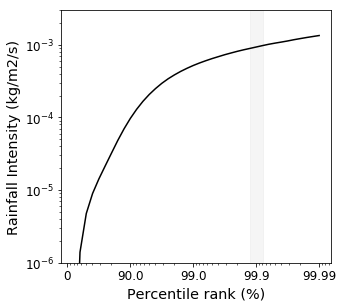

In [43]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_yscale('log')
ax.set_ylim((1e-6,3e-3))

# iQ_plot = slice(iQ_min,iQ_max)

# Grey shading 
i_Q_lims = (iQ_slice.start+4, iQ_slice.stop-4)
subplotXShadingRanksILog(ax,results_dict['ranks_ref'],i_Q_lims,alpha=0.15,transformX=False)
subplotRanksILog(ax,results_dict['ranks_ref'],[results_dict['percentiles']],col=['k'],ltype=['-'],\
                 transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel('Rainfall Intensity (kg/m2/s)')

plt.savefig(os.path.join(figdir,'talkAGU2017_pdf_pr_grayzone_%s.pdf'%(output_suffix_1scale)),
            bbox_inches='tight',transparent=True)

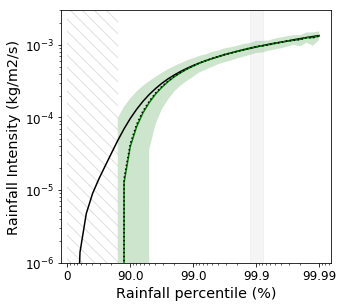

In [73]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_yscale('log')
ax.set_ylim((1e-6,3e-3))

# Grey shading 
i_Q_lims = (iQ_slice.start+4, iQ_slice.stop-4)
subplotXShadingRanksILog(ax,results_dict['ranks_ref'],i_Q_lims,alpha=0.15,transformX=False)
# 90% confidence interval for pointwise scaling 2
subplotYShadingRanksILog(ax,results_dict['ranks_ref'],[results_dict['pr_sc_I90'][:,0],results_dict['pr_sc_I90'][:,1]],
                         col='green',transformX=False)
# Interquartile range for pointwise scaling 2
# subplotYShadingRanksILog(ax,results_dict['ranks_ref'],[results_dict['pr_sc_IQR'][:,0],results_dict['pr_sc_IQR'][:,1]],
#                          col='green',transformX=False)
# Mean of pointwise scaling 2
subplotRanksILog(ax,results_dict['ranks_ref'],[results_dict['percentiles'],results_dict['pr_sc_prQ'],
                                               results_dict['pr_sc_vQ']],col=['k','green','k'],ltype=['-','-',':'],\
                 transformX=False)

addXHatchRanksILog(ax,results_dict['ranks_ref'],(0,iQ_min),color='gray',alpha=0.25,hatch='\\\\',transformX=True)

ax.set_xlabel('Rainfall percentile (%)')
ax.set_ylabel('Rainfall Intensity (kg/m2/s)')

plt.savefig(os.path.join(figdir,'talkAGU2017_pdf_pr_and_pr_sc_mean_I90_grayzone_%s.pdf'%(output_suffix_1scale)),
            bbox_inches='tight',transparent=True)

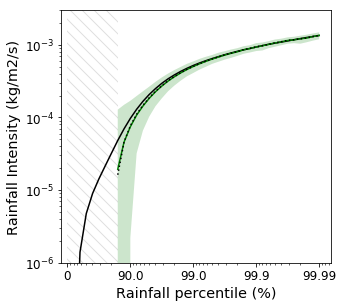

In [74]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_yscale('log')
ax.set_ylim((1e-6,3e-3))

# Grey shading 
i_Q_lims = (iQ_slice.start+4, iQ_slice.stop-4)
# subplotXShadingRanksILog(ax,results_dict['ranks_ref'],i_Q_lims,alpha=0.15,transformX=False)
# 90% confidence interval for pointwise scaling 2
subplotYShadingRanksILog(ax,results_dict['ranks_ref'],[results_dict['pr_scOGS09_I90'][:,0],
                                                       results_dict['pr_scOGS09_I90'][:,1]],
                         col='green',transformX=False)
subplotRanksILog(ax,results_dict['ranks_ref'],[results_dict['percentiles'],results_dict['pr_scOGS09_prQ'],
                                               results_dict['pr_scOGS09_vQ']],col=['k','green','k'],ltype=['-','-',':'],\
                 transformX=False)

addXHatchRanksILog(ax,results_dict['ranks_ref'],(0,iQ_min),color='gray',alpha=0.25,hatch='\\\\',transformX=True)

ax.set_xlabel('Rainfall percentile (%)')
ax.set_ylabel('Rainfall Intensity (kg/m2/s)')

plt.savefig(os.path.join(figdir,'talkAGU2017_pdf_pr_and_pr_scOGS09_mean_I90_%s.pdf'%(output_suffix_1scale)),
            bbox_inches='tight',transparent=True)

## Decomposition of the variance

> plot variance and corresponding contributions


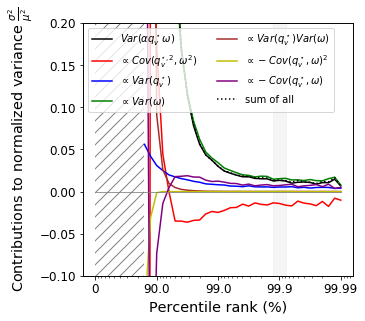

CPU times: user 754 ms, sys: 26.6 ms, total: 781 ms
Wall time: 779 ms


In [46]:
%%time
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.3,.6))

# Grey shading 
i_Q_lims = (iQ_slice.start+4, iQ_slice.stop-4)
subplotXShadingRanksILog(ax,results_dict['ranks_ref'],i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,results_dict['ranks_ref'])

subplotRanksILog(ax,results_dict['ranks_ref'],
                 results_dict['norm_var_pr_sc_prQ'],
                 col='k',ltype='-',transformX=False)
subplotRanksILog(ax,results_dict['ranks_ref'],
                 [results_dict['contribQOmega_var_covQ2Omega2'],
                  results_dict['contribQOmega_var_varQ'],
                  results_dict['contribQOmega_var_varOmega'],
                  results_dict['contribQOmega_var_varQvarOmega'],
                  results_dict['contribQOmega_var_cov2QOmega'],
                  results_dict['contribQOmega_var_covQOmega'],
                  results_dict['contribQOmega_var_sum']],
                 col=['r','b','g','brown','y','purple','k'],ltype=['-','-','-','-','-','-',':'],transformX=False)

addXHatchRanksILog(ax,results_dict['ranks_ref'],(0,iQ_min),transformX=True)

leg = ax.legend([r'$Var(\alpha q_v^\star \omega)$',
                 r'$\propto Cov(q_v^{\star,2},\omega^2)$',
                 r'$\propto Var(q_v^\star)$',
                 r'$\propto Var(\omega)$',
                 r'$\propto Var(q_v^\star)Var(\omega)$',
                 r'$\propto -Cov(q_v^\star,\omega)^2$',
                 r'$\propto -Cov(q_v^\star,\omega)$',
                 r'sum of all'],
                 loc='upper left',
                 framealpha=0.8,
                 ncol=2)

ax.set_ylim((-0.1,0.2))

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Contributions to normalized variance $\frac{\sigma^2}{\mu^2}$')

# plt.savefig(os.path.join(figdir,'talkAGU2017_var_and_contributions_omega_q_%s.pdf'%output_suffix_1scale),
#             bbox_inches='tight')

plt.show()

> plot variance and corresponding contributions


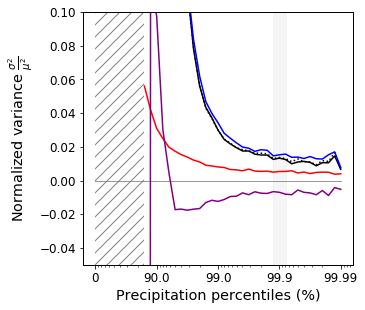

CPU times: user 745 ms, sys: 61.7 ms, total: 807 ms
Wall time: 827 ms


In [47]:
%%time
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.3,.6))

# Grey shading 
i_Q_lims = (iQ_slice.start+4, iQ_slice.stop-4)
subplotXShadingRanksILog(ax,results_dict['ranks_ref'],i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,results_dict['ranks_ref'])

# Variance
subplotRanksILog(ax,results_dict['ranks_ref'],
                 results_dict['norm_var_pr_sc_prQ'],
                 col='k',ltype='-',transformX=False)

c_varQ = results_dict['contribQOmega_var_varQ']
c_varOm = results_dict['contribQOmega_var_varOmega']
c_cov = results_dict['contribQOmega_var_covQOmega'] + results_dict['contribQOmega_var_covQ2Omega2']

# Contributions
ax2 = ax.twinx()
subplotRanksILog(ax2,results_dict['ranks_ref'],
                 [c_varQ,
                  c_varOm,
                  c_cov],
                 col=['r','b','purple'],ltype=['-','-','-'],transformX=False)
# Sum
subplotRanksILog(ax,results_dict['ranks_ref'],
                 c_varQ+c_varOm+c_cov,
                 col='k',ltype=':',transformX=False)

addXHatchRanksILog(ax,results_dict['ranks_ref'],(0,iQ_min),transformX=True)

# leg = ax.legend([r'variance of scaling',
#                  r'contribution in $Var(q_v^\star)$',
#                  r'contribution in $Var(\omega)$',
#                  r'covariance term'],
#                  loc='upper left',
#                  framealpha=0.95,
#                  ncol=1)

# leg = ax.legend([r'variance of scaling',
#                  r'sum of contributions'],
#                  loc='upper right',
#                  framealpha=0.95,
#                  ncol=1)


ax.set_ylim((-0.05,0.1))
ax2.set_ylim((-0.05,0.1))
ax2.axes.get_yaxis().set_visible(False)

ax.set_xlabel('Precipitation percentiles (%)')
ax.set_ylabel(r'Normalized variance $\frac{\sigma^2}{\mu^2}$')

plt.savefig(os.path.join(figdir,'talkAGU2017_var_sc_%s.pdf'%output_suffix_1scale),
            bbox_inches='tight')

plt.show()

> plot variance and corresponding contributions


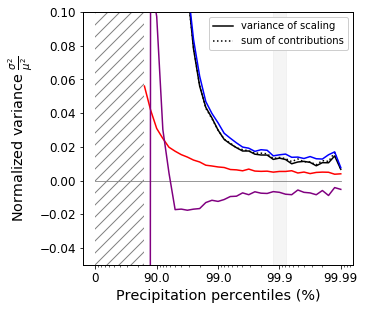

CPU times: user 907 ms, sys: 53.1 ms, total: 960 ms
Wall time: 952 ms


In [48]:
%%time
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.3,.6))

# Grey shading 
i_Q_lims = (iQ_slice.start+4, iQ_slice.stop-4)
subplotXShadingRanksILog(ax,results_dict['ranks_ref'],i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,results_dict['ranks_ref'])

# Variance
subplotRanksILog(ax,results_dict['ranks_ref'],
                 results_dict['norm_var_pr_sc_prQ'],
                 col='k',ltype='-',transformX=False)

c_varQ = results_dict['contribQOmega_var_varQ']
c_varOm = results_dict['contribQOmega_var_varOmega']
c_cov = results_dict['contribQOmega_var_covQOmega'] + results_dict['contribQOmega_var_covQ2Omega2']

# Contributions
ax2 = ax.twinx()
subplotRanksILog(ax2,results_dict['ranks_ref'],
                 [c_varQ,
                  c_varOm,
                  c_cov],
                 col=['r','b','purple'],ltype=['-','-','-'],transformX=False)
# Sum
subplotRanksILog(ax,results_dict['ranks_ref'],
                 c_varQ+c_varOm+c_cov,
                 col='k',ltype=':',transformX=False)

addXHatchRanksILog(ax,results_dict['ranks_ref'],(0,iQ_min),transformX=True)

# leg = ax.legend([r'variance of scaling',
#                  r'contribution in $Var(q_v^\star)$',
#                  r'contribution in $Var(\omega)$',
#                  r'covariance term'],
#                  loc='upper left',
#                  framealpha=0.95,
#                  ncol=1)

leg = ax.legend([r'variance of scaling',
                 r'sum of contributions'],
                 loc='upper right',
                 framealpha=0.95,
                 ncol=1)


ax.set_ylim((-0.05,0.1))
ax2.set_ylim((-0.05,0.1))
ax2.axes.get_yaxis().set_visible(False)

ax.set_xlabel('Precipitation percentiles (%)')
ax.set_ylabel(r'Normalized variance $\frac{\sigma^2}{\mu^2}$')

plt.savefig(os.path.join(figdir,'talkAGU2017_var_and_contributions_omega_q_%s.pdf'%output_suffix_1scale),
            bbox_inches='tight')

plt.show()

> plot variance and corresponding contributions


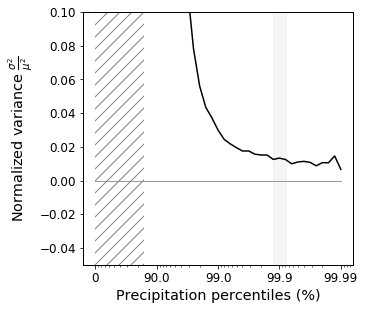

CPU times: user 731 ms, sys: 89.3 ms, total: 820 ms
Wall time: 817 ms


In [49]:
%%time
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.3,.6))

# Grey shading 
i_Q_lims = (iQ_slice.start+4, iQ_slice.stop-4)
subplotXShadingRanksILog(ax,results_dict['ranks_ref'],i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,results_dict['ranks_ref'])

# Variance
subplotRanksILog(ax,results_dict['ranks_ref'],
                 results_dict['norm_var_pr_sc_prQ'],
                 col='k',ltype='-',transformX=False)

c_varQ = results_dict['contribQOmega_var_varQ']
c_varOm = results_dict['contribQOmega_var_varOmega']
c_cov = results_dict['contribQOmega_var_covQOmega'] + results_dict['contribQOmega_var_covQ2Omega2']

# Contributions
ax2 = ax.twinx()
# subplotRanksILog(ax2,results_dict['ranks_ref'],
#                  [c_varQ,
#                   c_varOm,
#                   c_cov],
#                  col=['r','b','purple'],ltype=['-','-','-'],transformX=False)
# # Sum
# subplotRanksILog(ax,results_dict['ranks_ref'],
#                  c_varQ+c_varOm+c_cov,
#                  col='k',ltype=':',transformX=False)

addXHatchRanksILog(ax,results_dict['ranks_ref'],(0,iQ_min),transformX=True)

# leg = ax.legend([r'variance of scaling',
#                  r'contribution in $Var(q_v^\star)$',
#                  r'contribution in $Var(\omega)$',
#                  r'covariance term'],
#                  loc='upper left',
#                  framealpha=0.95,
#                  ncol=1)

# leg = ax.legend([r'variance of scaling'],
#                  loc='upper right',
#                  framealpha=0.95,
#                  ncol=1)


ax.set_ylim((-0.05,0.1))
ax2.set_ylim((-0.05,0.1))
ax2.axes.get_yaxis().set_visible(False)

ax.set_xlabel('Precipitation percentiles (%)')
ax.set_ylabel(r'Normalized variance $\frac{\sigma^2}{\mu^2}$')

plt.savefig(os.path.join(figdir,'talkAGU2017_var_%s.pdf'%output_suffix_1scale),
            bbox_inches='tight')

plt.show()

## 2D PDFS

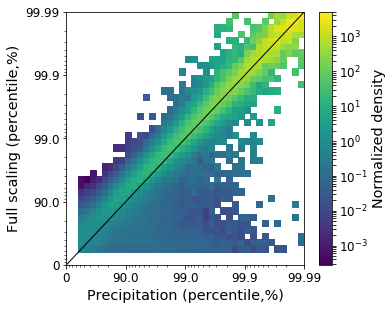

In [52]:
varname1 = 'pr'
varname2 = 'pr_scOGS09'

norm_density2D_name = "norm_density2D_%s_%s"%(varname1,varname2)

fig, ax = plt.subplots(figsize=(5.5,4.5))

# cmap = plt.cm.RdBu_r
# cmap = plt.cm.RdGy_r
# cmap = plt.cm.RdYlBu_r
# cmap = plt.cm.PRGn
cmap = plt.cm.viridis

cb = subplot2DRanksILog(ax,ranks_ref,ranks_ref,results_dict[norm_density2D_name],cmap=cmap,
        transformX=True,transformY=True,Z_mode='log',range_type='full_positive')

cb.ax.set_ylabel('Normalized density')

add1to1Line(ax)

ax.set_xlabel('Precipitation (percentile,%)')
ax.set_ylabel('Full scaling (percentile,%)')
# ax.set_title(r'with $\alpha=1$:')

plt.savefig(os.path.join(figdir,'talkAGU2017_norm_pdf2D_%s_and_%s_%s.pdf'%(varname1,varname2,output_suffix_1scale)),
                bbox_inches='tight')
plt.show()

# Multiscale figures

## epsilon for both scalings as a function of scale

In [88]:
print([v for v in all_varids if v.startswith('eps')])

['eps', 'eps_OGS09', 'eps_OGS09ad']


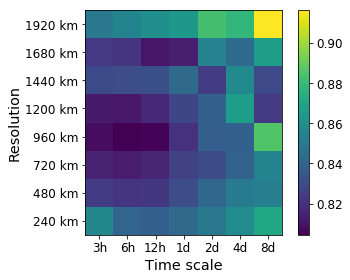

In [89]:
eps_ms = getTXVarFromResults('eps',results,time_strides,resolutions,avg_mode='mean',var_type='scalar')

fig, ax = plt.subplots(ncols=1,nrows=1)
cb = subplotMultiscaleVar(ax,eps_ms,time_strides)
# addHatchBelowThreshold(ax,N_prQ_Q30,40)
plt.savefig(os.path.join(figdir,'talkAGU2017_eps_pr_sc_%s.pdf'%(output_suffix_1scale)),
            bbox_inches='tight',transparent=True)

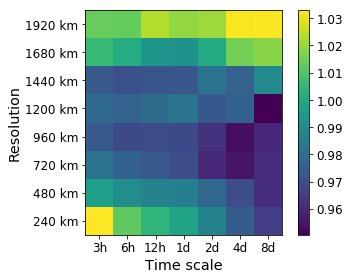

In [90]:
eps_OGS09_ms = getTXVarFromResults('eps_OGS09',results,time_strides,resolutions,avg_mode='mean',var_type='scalar')

fig, ax = plt.subplots(ncols=1,nrows=1)
cb = subplotMultiscaleVar(ax,eps_OGS09_ms,time_strides)
# addHatchBelowThreshold(ax,N_prQ_Q30,40)
plt.savefig(os.path.join(figdir,'talkAGU2017_eps_OGS09_pr_sc_%s.pdf'%(output_suffix_1scale)),
            bbox_inches='tight',transparent=True)

## Normalized variance

In [91]:
print("import 1D percentile-dependent variables")
varids_to_sum = set(('N_prQ',))
varids_to_avg = [v for v in all_varids if (v.startswith('norm_') and v.endswith('_prQ')) or v.startswith('contrib')]
varids_to_avg.extend([v for v in all_varids if v.startswith('pr')])
varids_not_to_avg = [v for v in all_varids if v.endswith('_I90') or v.endswith('_IQR')]
varids_to_avg = set(varids_to_avg).difference(set(varids_not_to_avg))

import 1D percentile-dependent variables


In [92]:
print("load all variables as a function of time_stride and resolution")

ranks_ref = results[time_strides[0]][resolutions[0]]['ranks_ref']
iQ999 = indexOfRank(99.9,ranks_ref)
iQ_slice = slice(iQ999-5,iQ999+5)

iQ_label = "Q%d_Q%d"%(iQ_slice.start,iQ_slice.stop)

for varid in varids_to_avg:
    newvarid = "%s_%s"%(varid,iQ_label)
    newvar = getTXVarFromResults(varid,results,time_strides,resolutions,iQ_slice,avg_mode='mean')
    setattr(thismodule,newvarid,newvar)

for varid in ('N_prQ',):
    newvarid = "%s_Q%s"%(varid,iQ999)
    newvar = getTXVarFromResults(varid,results,time_strides,resolutions,slice(iQ999,iQ999+1),avg_mode='sum')
    setattr(thismodule,newvarid,newvar)


load all variables as a function of time_stride and resolution


In [93]:
print("compute normalizes bias")
norm_bias_pr_sc_prQ_Q25_Q35 = 1-(pr_sc_vQ_Q25_Q35/pr_sc_prQ_Q25_Q35)

compute normalizes bias


In [94]:
print("sum of covariance terms")
contribQOmega_var_allcov_Q25_Q35 = contribQOmega_var_covQOmega_Q25_Q35+contribQOmega_var_covQ2Omega2_Q25_Q35
contribTOmega_var_allcov_Q25_Q35 = contribTOmega_var_covTOmega_Q25_Q35+contribTOmega_var_covTOmega2_Q25_Q35

sum of covariance terms


In [95]:
# mask = (norm_var_pr_sc_I25_prQ_Q25_Q35-norm_var_pr_sc_I75_prQ_Q25_Q35)
# mask[np.isnan(mask)] = np.inf
# mask_noisy = mask >0

In [96]:
mask_noisy = N_prQ_Q30 < 30


In [97]:
print("> Plot normalized variability and contributions")

varids_to_plot = [v for v in locals() if v.endswith(iQ_label) and v.startswith('contrib')]

## Plot bias and variability
for varid in ['norm_bias_pr_sc_prQ_Q25_Q35','norm_var_pr_sc_prQ_Q25_Q35']:
    var = getattr(thismodule,varid)
    # Plot
    fig, ax = plt.subplots(ncols=1,nrows=1)
    if varid.startswith('norm_var_'):
        vmin = 0; vmax = 0.05
        subplotMultiscaleVar(ax,var,time_strides,cmap=plt.cm.Spectral,vmin=vmin,vmax=vmax)
        ax.set_title('Normalized variance')
    elif varid.startswith('norm_bias_'):
        subplotMultiscaleVar(ax,var,time_strides)
        ax.set_title('Normalized bias')
#     addHatchBelowThreshold(ax,N_prQ_Q30,40)
    addHatchOnMask(ax,mask_noisy)
    plt.savefig(os.path.join(figdir,'%s_%s.pdf'%(varid,dates_label.replace('-','_'))),bbox_inches='tight')
    plt.close()

## Plot all contributions
for varid in varids_to_plot:
    if '_var_' in varid:
        var = getattr(thismodule,varid)/norm_var_pr_sc_prQ_Q25_Q35*100
    elif '_bias_' in varid:
        var = getattr(thismodule,varid)/norm_bias_pr_sc_prQ_Q25_Q35*100
    # Plot
    fig, ax = plt.subplots(ncols=1,nrows=1)
    subplotMultiscaleVar(ax,var,time_strides,cmap=plt.cm.Spectral,vmin=-120,vmax=120)
    addHatchBelowThreshold(ax,N_prQ_Q30,40)
    plt.savefig(os.path.join(figdir,'fraction_%s_%s.pdf'%(varid,dates_label.replace('-','_'))),bbox_inches='tight')
    plt.close()


> Plot normalized variability and contributions


# Multiscale numbers

In [103]:
print("compute numbers:")
print()
numbers_names = 'eps','eps_OGS09','norm_var_pr_sc_prQ','norm_var_pr_scOGS09_prQ'

for experiment in 'piControl','abrupt4xCO2':
    for compset in 'FSPCAMm_AMIP','FAMIPC5':

        # Load all results
        results_d = {}
        for time_stride in time_strides:
            results_d[time_stride] = {}
            for resolution in resolutions:
                resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,member,subset)
                filename = 'results_dictionary_%s_%s.pickle'%(ranks_label,dates_label)
                filepath = os.path.join(resultdir,time_stride,resolution,filename)
                results_d[time_stride][resolution] = pickle.load(open(filepath,'rb'))

        print(experiment,compset,":")
        # Compute numbers for table
        N_prQ_Q30 = getTXVarFromResults('N_prQ',results_d,time_strides,resolutions,slice(iQ999,iQ999+1),avg_mode='sum')
        mask = N_prQ_Q30 < 30
        for number_name in 'eps','eps_OGS09':
            var = getTXVarFromResults(number_name,results_d,time_strides,resolutions,avg_mode='mean',var_type='scalar')
            var[mask] = np.nan
            var_meanscales = np.nanmean(var)
            print(number_name,'=',var_meanscales)
        for number_name in 'norm_var_pr_sc_prQ','norm_var_pr_scOGS09_prQ':
            var = getTXVarFromResults(number_name,results_d,time_strides,resolutions,iQ_slice=iQ_slice,avg_mode='mean')
            var[mask] = np.nan
            var_meanscales = np.nanmean(var)
            print(number_name,'=',var_meanscales)
            print('corresponding 2sigma-error =',2*sqrt(var_meanscales))
        print()

compute numbers:

piControl FSPCAMm_AMIP :
eps = 0.830665474437
eps_OGS09 = 0.986677275597
norm_var_pr_sc_prQ = 0.0173220787701
corresponding 2sigma-error = 0.26322673701658716
norm_var_pr_scOGS09_prQ = 0.00801055972396
corresponding 2sigma-error = 0.17900346056950303

piControl FAMIPC5 :
eps = 0.86167523158
eps_OGS09 = 1.0545808771
norm_var_pr_sc_prQ = 0.0309130771411
corresponding 2sigma-error = 0.3516423020120275
norm_var_pr_scOGS09_prQ = 0.0257825368675
corresponding 2sigma-error = 0.3211388289666598

abrupt4xCO2 FSPCAMm_AMIP :
eps = 0.825063110711
eps_OGS09 = 0.984419648805
norm_var_pr_sc_prQ = 0.0119978084758
corresponding 2sigma-error = 0.21906901630134565
norm_var_pr_scOGS09_prQ = 0.0069040658292
corresponding 2sigma-error = 0.16618141688166882

abrupt4xCO2 FAMIPC5 :
eps = 0.909574964542
eps_OGS09 = 1.07628611319
norm_var_pr_sc_prQ = 0.0296100443641
corresponding 2sigma-error = 0.34415138741031825
norm_var_pr_scOGS09_prQ = 0.0307016681954
corresponding 2sigma-error = 0.35043783